In [31]:
import os
import numpy as np
from PIL import Image
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Load Images into Sequences

In [2]:
def load_sequences_by_pattern(real_folder, gen_folder, real_indices, gen_indices, real_pattern='PANC-1_{i}_real_B.png', gen_pattern='step{i}_generated_fake_B.png', image_size=(224, 224)):
    real_images = []
    gen_images = []

    for i in real_indices:
        real_path = os.path.join(real_folder, real_pattern.format(i=i))
        if not os.path.exists(real_path):
            print(f"[!] Missing real image: {real_path}")
            continue
        img = Image.open(real_path).convert('RGB').resize(image_size)
        real_images.append(np.array(img) / 255.0)

    for i in gen_indices:
        gen_path = os.path.join(gen_folder, gen_pattern.format(i=i))
        if not os.path.exists(gen_path):
            print(f"[!] Missing generated image: {gen_path}")
            continue
        img = Image.open(gen_path).convert('RGB').resize(image_size)
        gen_images.append(np.array(img) / 255.0)

    real_seq = np.stack(real_images, axis=0)
    gen_seq = np.stack(gen_images, axis=0)

    return real_seq, gen_seq

In [147]:
real_folder1= "C:\\Users\\Jesus\\Documents\\TFM\\PROYECTO4\\results\\dualseq-CSIC-top_left\\dualseq-bt_rg-v1\\test_latest\\images\\"
real_folder2= "C:\\Users\\Jesus\\Documents\\TFM\\PROYECTO3\\csic\\top_left\\"
gen_folder1 = "C:\\Users\\Jesus\\Documents\\TFM\\PROYECTO4\\results\\dualseq-CSIC-top_left_recur2\\dualseq-bt_rg-v1_sketch\\test_latest\\images\\"
#real_pattern='PANC-1_{i}.jpg',
#real_pattern='PANC-1_{i}_real_A.png',
#gen_pattern ='step{i}_generated_fake_B.png',
gen_folder = "C:\\Users\\Jesus\\Documents\\TFM\\PROYECTO4\\results\\dualseq-basic1_recur\\dualseq-basic-v1\\test_latest\\images\\"
real_folder = "C:\\Users\\Jesus\\Documents\\TFM\\PROYECTO2\\results\\seq-basic-v1\\test_latest\\images\\"

real_seq, gen_seq = load_sequences_by_pattern(
    real_folder=real_folder,
    gen_folder=gen_folder,
    real_indices=range(280, 295),
    gen_indices= range(0, 15),
    real_pattern='{i}_real_B.png',
    gen_pattern ='step{i}_generated_fake_B.png',
    image_size=(256, 256)
)

print("Real sequence shape:", real_seq.shape)
print("Generated sequence shape:", gen_seq.shape)

Real sequence shape: (15, 256, 256, 3)
Generated sequence shape: (15, 256, 256, 3)


## Embedding Distasnce

In [4]:
def compute_embedding_distance(real_feats, gen_feats, metric='cosine'): #### COSINE OR EUCLIDEN
    from sklearn.metrics.pairwise import cosine_similarity
    if metric == 'cosine':
        sims = cosine_similarity(real_feats, gen_feats)
        distances = 1 - np.diag(sims)
    elif metric == 'euclidean':
        distances = np.linalg.norm(real_feats - gen_feats, axis=1)
    else:
        raise ValueError("Unsupported metric")
    return np.mean(distances)

## Motion Consistency Score 

In [5]:
def compute_motion_consistency(real_seq, gen_seq):
    flow_sims = []
    for i in range(len(real_seq) - 1):
        r1 = cv2.cvtColor((real_seq[i] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        r2 = cv2.cvtColor((real_seq[i + 1] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        g1 = cv2.cvtColor((gen_seq[i] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        g2 = cv2.cvtColor((gen_seq[i + 1] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        flow_r = cv2.calcOpticalFlowFarneback(r1, r2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_g = cv2.calcOpticalFlowFarneback(g1, g2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        fr = flow_r.reshape(-1, 2)
        fg = flow_g.reshape(-1, 2)

        sim = np.mean([
            np.dot(fr[j], fg[j]) / (np.linalg.norm(fr[j]) * np.linalg.norm(fg[j]) + 1e-6)
            for j in range(len(fr))
        ])
        flow_sims.append(sim)
    return np.mean(flow_sims)

## Optical Flow Consistency

In [6]:
def compute_optical_flow_consistency(sequence):
    total_flow_magnitude = 0.0
    count = 0

    for i in range(len(sequence) - 1):
        prev = cv2.cvtColor((sequence[i] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        next = cv2.cvtColor((sequence[i+1] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev, next, None,
                                            pyr_scale=0.5, levels=3, winsize=15,
                                            iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        total_flow_magnitude += np.mean(mag)
        count += 1

    return total_flow_magnitude / count

## Trajectory Diversity Score

In [7]:
def compute_trajectory_diversity(sequence):
    diffs = []
    for i in range(len(sequence) - 1):
        diff = np.linalg.norm(sequence[i + 1] - sequence[i])
        diffs.append(diff)
    return np.mean(diffs)

### Feature extraction

In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Cargar modelo preentrenado sin la capa final (solo features)
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights).to(device).eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1])

In [149]:
def extract_video_feature(sequence_np, model, device='cuda'):
    transform = T.Compose([
        T.ToTensor(),  # C,H,W
        T.Resize((112, 112)),
        T.Normalize(mean=[0.43216, 0.394666, 0.37645],
                    std=[0.22803, 0.22145, 0.216989])
    ])

    frames = [
        transform(Image.fromarray((frame * 255).astype(np.uint8)).convert("RGB")).unsqueeze(0)
        for frame in sequence_np
    ]

    video_tensor = torch.cat(frames, dim=0).permute(1, 0, 2, 3)  # C,T,H,W
    video_tensor = video_tensor.unsqueeze(0).to(device).float()

    with torch.no_grad():
        features = model(video_tensor).cpu().numpy().reshape(-1)

    return features  # (512,)

In [150]:
real_feats = extract_video_feature(real_seq, feature_extractor, device).reshape(1, -1)
gen_feats = extract_video_feature(gen_seq, feature_extractor, device).reshape(1, -1)

In [151]:
print("real_feats shape:", real_feats.shape)
print("gen_feats shape:", gen_feats.shape)

real_feats shape: (1, 512)
gen_feats shape: (1, 512)


In [152]:
real_feats = np.stack([extract_video_feature(seq, model, device) for seq in real_seq])
gen_feats = np.stack([extract_video_feature(seq, model, device) for seq in gen_seq])

## FVD PyTorch version

In [153]:
def compute_frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_fvd_pytorch(real_feats, gen_feats):
    mu_r, sigma_r = np.mean(real_feats, axis=0), np.cov(real_feats.T)
    mu_g, sigma_g = np.mean(gen_feats, axis=0), np.cov(gen_feats.T)
    return compute_frechet_distance(mu_r, sigma_r, mu_g, sigma_g)

## Evaluator

In [154]:
def evaluate_sequence_metrics(real_seq, gen_seq, real_feats=None, gen_feats=None):
    metrics = {}
    metrics_real = {}

    metrics["FVD"] = compute_fvd_pytorch(real_feats, gen_feats)
    metrics["Embedding Distance"] = compute_embedding_distance(real_feats, gen_feats)
    metrics["Motion Consistency"] = compute_motion_consistency(real_seq, gen_seq)
    
    metrics["Optical Flow Consistency"] = compute_optical_flow_consistency(gen_seq)
    metrics["Trajectory Diversity"] = compute_trajectory_diversity(gen_seq)
    metrics_real["Optical Flow Consistency"] = compute_optical_flow_consistency(real_seq)
    metrics_real["Trajectory Diversity"] = compute_trajectory_diversity(real_seq)
    
    return metrics, metrics_real

In [155]:
metrics, metrics_real = evaluate_sequence_metrics(real_seq, gen_seq, real_feats, gen_feats)
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

print("\nRealistic sequence metrics:")
for name, value in metrics_real.items():
    print(f"{name}: {value:.4f}")

FVD: 105.8050
Embedding Distance: 0.0163
Motion Consistency: -0.0071
Optical Flow Consistency: 0.1071
Trajectory Diversity: 7.0923

Realistic sequence metrics:
Optical Flow Consistency: 0.2160
Trajectory Diversity: 9.2912


### Optical Flow Consistency VS Trajectory Diversity

In [156]:
flow_gen = metrics.get("Optical Flow Consistency", None)
traj_gen = metrics.get("Trajectory Diversity", None)
flow_real = metrics_real.get("Optical Flow Consistency", None)
traj_real = metrics_real.get("Trajectory Diversity", None)

if None in [flow_gen, traj_gen, flow_real, traj_real]:
    raise ValueError("Faltan métricas necesarias en los diccionarios.")

labels = ['Optical Flow Consistency', 'Trajectory Diversity']
generated = [flow_gen, traj_gen]
real = [flow_real, traj_real]

x = np.arange(len(labels))  # posiciones en eje X
width = 0.35  # ancho de barra

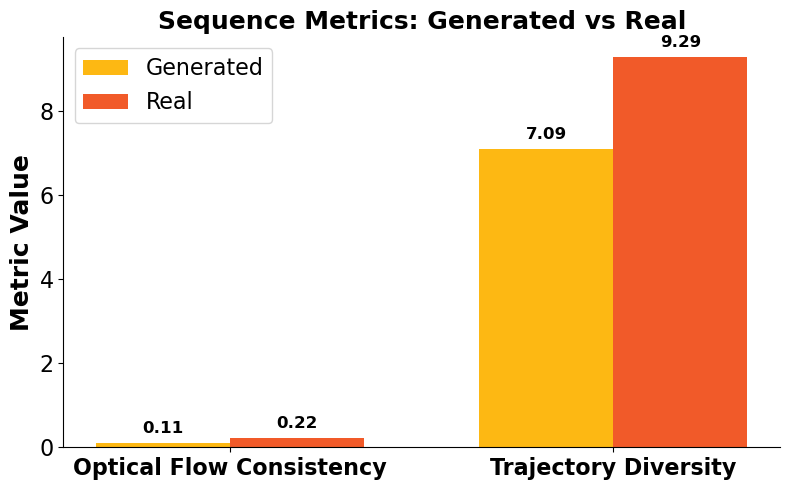

In [157]:
fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, generated, width, label='Generated', color='#FDB813') 
bars2 = ax.bar(x + width/2, real, width, label='Real', color='#F15A29')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight="bold")

annotate_bars(bars1)
annotate_bars(bars2)

ax.set_ylabel('Metric Value', fontsize=18, fontweight="bold")
ax.set_title('Sequence Metrics: Generated vs Real', fontsize=18, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16, fontweight="bold")
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=16)

ax.spines[['top', 'right']].set_visible(False) 
plt.tight_layout()
plt.show()
